
<div style="background-color:#DAAAA1; color:#19180F; font-size:40px; font-family:Verdana; padding:10px">
 Table of Contents    

</div>

<div style="background-color:#CDC997; color:#19180F; font-size:20px; font-family:Verdana; padding:10px">
<br>
1. Data Preprocessing.<br>
2. Exploratory Data Analysis.<br>
3. Feature Engineering.<br>
4. Model Selection.<br>
5. Hyperparameter tuning.<br>
6. Feature Importance.<br>
7. Model Interpretation.<br>
8. Generating Submission<br>
</div>




<div style="background-color:#CDC997; color:#19180F; font-size:20px; font-family:Verdana; padding:10px">

1. Data Preprocessing
    
</div>


<div style="background-color:#DAAAA1; color:#19180F; font-size:15px; font-family:Verdana; padding:10px">
The next code block imports the modules
</div>

In [1]:
#importing modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
# Handle missing values in train and test sets using iterative imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
plt.style.use('fivethirtyeight')
pd.options.display.max_columns = 81
pd.options.display.max_rows = 25

<div style="background-color:#DAAAA1; color:#19180F; font-size:15px; font-family:Verdana; padding:10px">

The next code block loads the train and test sets
    
</div>


In [3]:
#load the training and test datasets
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

<div style="background-color:#DAAAA1; color:#19180F; font-size:15px; font-family:Verdana; padding:10px">

The next codeblock performs the following functionality:<br>

1. It identifies the numerical columns in the DataFrame `train_df` that have data types of either `float64` or `int64` using the `select_dtypes` method.<br>

2. It removes the column named 'SalePrice' from the list of numerical columns.<br>

3. It creates an instance of the `IterativeImputer` class, which is used for imputing missing values in the data.<br>

4. It applies the imputer to fill in the missing values in the numerical columns of the `train_df` DataFrame using the `fit_transform` method. This replaces the missing values with estimated values based on the other available data.<br>

5. It also applies the imputer to fill in the missing values in the numerical columns of the `test_df` DataFrame using the `transform` method. The `transform` method uses the information learned from the `train_df` data to impute the missing values in the `test_df` data, ensuring consistency.<br>


</div>


In [4]:
num_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
num_cols = num_cols.drop('SalePrice') # Remove SalePrice column
imputer = IterativeImputer(verbose=2)
train_df[num_cols] = imputer.fit_transform(train_df[num_cols])
test_df[num_cols] = imputer.transform(test_df[num_cols])

[IterativeImputer] Completing matrix with shape (1460, 37)
[IterativeImputer] Ending imputation round 1/10, elapsed time 1.52
[IterativeImputer] Change: 186.14381421467823, scaled tolerance: 215.245 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (1459, 37)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.01


<div style="background-color:#DAAAA1; color:#19180F; font-size:15px; font-family:Verdana; padding:10px">

The next codeblock performs the following functionality:<br>

1. It creates an instance of the `StandardScaler` class, which is used for standardizing numerical features by removing the mean and scaling to unit variance.<br>

2. It applies the scaler to standardize the numerical columns in the `train_df` DataFrame using the `fit_transform` method. This computes the mean and standard deviation of each column in the `num_cols` list and then scales the values accordingly.<br>

3. It also applies the scaler to standardize the numerical columns in the `test_df` DataFrame using the `transform` method. The `transform` method uses the mean and standard deviation computed from the `train_df` data to perform the same scaling on the `test_df` data, ensuring consistency.<br>

</div>


In [5]:
# Scale numerical features in train and test sets
scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])


<div style="background-color:#DAAAA1; color:#19180F; font-size:15px; font-family:Verdana; padding:10px">

The next codeblock encodes categorical variables in the train and test sets using the `LabelEncoder` class. The steps are:<br>

1. It identifies the categorical columns in the `train_df` DataFrame by selecting columns with the data type 'object' using the `select_dtypes` method.<br>

2. It initializes a `LabelEncoder` object `le` for each categorical column.<br>

3. It fits the label encoder on the combined values of the current column in both the `train_df` and `test_df` DataFrames. <br>

4. It transforms the values in the current column of the `train_df` DataFrame using the `transform` method of the label encoder. This replaces the original categorical values with their corresponding encoded integer values.<br>

5. Similarly, it transforms the values in the current column of the `test_df` DataFrame using the `transform` method.<br>


 
</div>


In [6]:
# Encode categorical variables in train and test sets
cat_cols = train_df.select_dtypes(include=['object']).columns
for col in cat_cols:
    le = LabelEncoder()
    le.fit(list(train_df[col].astype(str).values) + list(test_df[col].astype(str).values))
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))


<div style="background-color:#DAAAA1; color:#19180F; font-size:15px; font-family:Verdana; padding:10px">

Displaying the train_df and test_df to check its transformation in next code blocks
    
</div>


In [7]:
train_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,-1.730865,0.073375,3,-0.240987,-0.207142,1,2,3,3,0,4,0,5,2,2,0,5,0.651479,-0.517200,1.050994,0.878668,1,1,12,13,1,0.509269,2,4,2,2,3,3,2,0.575425,5,-0.288653,-0.944591,-0.459303,1,0,1,4,-0.793434,1.161852,-0.120242,0.370333,1.107810,-0.241061,0.789741,1.227585,0.163779,-0.211454,2,0.912210,6,-0.951226,5,1,1.035549,1,0.311725,0.351000,4,4,2,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,3,4,4,-0.087688,-1.599111,0.138777,8,4,208500
1,-1.728492,-0.872563,3,0.403227,-0.091886,1,2,3,3,0,2,0,24,1,2,0,2,-0.071836,2.179628,0.156734,-0.429577,1,1,8,8,2,-0.575909,3,4,1,2,3,1,0,1.171992,5,-0.288653,-0.641228,0.466465,1,0,1,4,0.257140,-0.795163,-0.120242,-0.482512,-0.819964,3.948809,0.789741,-0.761621,0.163779,-0.211454,3,-0.318683,6,0.600495,4,1,-0.025953,1,0.311725,-0.060731,4,4,2,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,3,4,4,-0.087688,-0.489110,-0.614439,8,4,181500
2,-1.726120,0.073375,3,-0.112144,0.073480,1,2,0,3,0,4,0,5,2,2,0,5,0.651479,-0.517200,0.984752,0.830215,1,1,12,13,1,0.321024,2,4,2,2,3,2,2,0.092907,5,-0.288653,-0.301643,-0.313369,1,0,1,4,-0.627826,1.189351,-0.120242,0.515013,1.107810,-0.241061,0.789741,1.227585,0.163779,-0.211454,2,-0.318683,6,0.600495,4,1,0.956919,1,0.311725,0.631726,4,4,2,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,3,4,4,-0.087688,0.990891,0.138777,8,4,223500
3,-1.723747,0.309859,3,-0.455725,-0.096897,1,2,0,3,0,0,0,6,2,2,0,5,0.651479,-0.517200,-1.863632,-0.720298,1,1,13,15,2,-0.575909,3,4,0,3,1,3,0,-0.499274,5,-0.288653,-0.061670,-0.687324,1,2,1,4,-0.521734,0.937276,-0.120242,0.383659,1.107810,-0.241061,-1.026041,-0.761621,0.163779,-0.211454,2,0.296763,6,0.600495,2,5,0.838974,2,1.650307,0.790804,4,4,2,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,3,4,4,-0.087688,-1.599111,-1.367655,8,0,140000
4,-1.721374,0.073375,3,0.575018,0.375148,1,2,0,3,0,2,0,15,2,2,0,5,1.374795,-0.517200,0.951632,0.733308,1,1,12,13,1,1.361910,2,4,2,2,3,0,2,0.463568,5,-0.288653,-0.174865,0.199680,1,0,1,4,-0.045611,1.617877,-0.120242,1.299326,1.107810,-0.241061,0.789741,1.227585,1.390023,-0.211454,2,1.527656,6,0.600495,4,1,0.917604,1,1.650307,1.698485,4,4,2,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,3,4,4,-0.087688,2.100892,0.138777,8,4,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.721374,0.073375,3,-0.369830,-0.260560,1,2,3,3,0,4,0,8,2,2,0,5,-0.071836,-0.517200,0.918511,0.733308,1,1,12,13,2,-0.575909,3,4,2,2,3,3,5,-0.973018,5,-0.288653,0.873321,-0.238122,1,0,1,4,-0.542435,0.795198,-0.120242,0.250402,-0.819964,-0.241061,0.789741,1.227585,0.163779,-0.211454,3,0.296763,6,0.600495,4,1,0.878289,1,0.311725,-0.060731,4,4,2,-0.752176,-0.100558,-0.359325,-0.116339,-0.270208,-0.068692,3,4,4,-0.087688,0.620891,-0.614439,8,4,175000
1456,1.723747,-0.872563,3,0.617965,0.266407,1,2,3,3,0,4,0,14,2,2,0,2,-0.071836,0.381743,0.222975,0.151865,1,1,9

In [8]:
test_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1.733238,-0.872563,2,0.403227,0.110763,1,2,3,3,0,4,0,12,1,2,0,2,-0.795151,0.381743,-0.340077,-1.156380,1,1,12,13,2,-0.575909,3,4,1,3,3,3,4,0.053428,3,0.604293,-0.672923,-0.400017,1,4,1,4,-0.689929,-0.795163,-0.120242,-1.179256,-0.819964,-0.241061,-1.026041,-0.761621,-1.062465,-0.211454,3,-0.934130,6,-0.951226,5,1,-0.615676,2,-1.026858,1.202536,4,4,2,0.365179,-0.704483,-0.359325,-0.116339,1.882709,-0.068692,3,2,4,-0.087688,-0.119110,1.645210,8,4
1,1.735610,-0.872563,3,0.446175,0.375850,1,2,0,3,0,0,0,12,2,2,0,2,-0.071836,0.381743,-0.439440,-1.301740,3,1,13,14,1,0.022046,3,4,1,3,3,3,0,1.051363,5,-0.288653,-0.365032,0.619239,1,4,1,4,0.430511,-0.795163,-0.120242,-0.354966,-0.819964,-0.241061,-1.026041,1.227585,0.163779,-0.211454,2,-0.318683,6,-0.951226,5,1,-0.733621,2,-1.026858,-0.753188,4,4,2,2.384400,-0.160950,-0.359325,-0.116339,-0.270208,-0.068692,3,4,0,25.116309,-0.119110,1.645210,8,4
2,1.737983,0.073375,3,0.145542,0.332053,1,2,0,3,0,4,0,8,2,2,0,5,-0.795151,-0.517200,0.852269,0.636400,1,1,12,13,2,-0.575909,3,4,2,2,3,3,2,0.761852,5,-0.288653,-0.974021,-0.295127,1,2,1,4,-0.607125,0.811239,-0.120242,0.216136,-0.819964,-0.241061,0.789741,1.227585,0.163779,-0.211454,3,-0.318683,6,0.600495,4,1,0.799659,0,0.311725,0.042202,4,4,2,0.939819,-0.191147,-0.359325,-0.116339,-0.270208,-0.068692,3,2,4,-0.087688,-1.229111,1.645210,8,4
3,1.740356,0.073375,3,0.317332,-0.054002,1,2,0,3,0,4,0,8,2,2,0,5,-0.071836,0.381743,0.885390,0.636400,1,1,12,13,1,-0.465177,3,4,2,3,3,3,2,0.347326,5,-0.288653,-0.550672,-0.299687,1,0,1,4,-0.612300,0.758532,-0.120242,0.168544,-0.819964,-0.241061,0.789741,1.227585,0.163779,-0.211454,2,0.296763,6,0.600495,2,1,0.838974,0,0.311725,-0.013943,4,4,2,2.121024,-0.160950,-0.359325,-0.116339,-0.270208,-0.068692,3,4,4,-0.087688,-0.119110,1.645210,8,4
4,1.742728,1.492282,3,-1.185834,-0.552407,1,2,0,1,0,4,0,22,2,2,4,2,1.374795,-0.517200,0.686666,0.345679,1,1,6,6,2,-0.575909,2,4,2,2,3,3,0,-0.396190,5,-0.288653,1.018211,0.507509,1,0,1,4,0.303718,-0.795163,-0.120242,-0.448246,-0.819964,-0.241061,0.789741,-0.761621,-1.062465,-0.211454,2,-0.934130,6,-0.951226,5,1,0.603085,1,0.311725,0.154492,4,4,2,-0.752176,0.533564,-0.359325,-0.116339,2.313293,-0.068692,3,4,4,-0.087688,-1.969111,1.645210,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,5.183104,2.438219,4,-2.130682,-0.859988,1,2,3,3,0,4,0,10,2,2,3,5,-1.518467,1.280685,-0.041991,-0.720298,1,1,5,5,2,-0.575909,3,4,1,3,3,3,5,-0.973018,5,-0.288653,-0.048086,-1.166169,1,2,1,4,-1.595596,0.456043,-0.120242,-0.806136,-0.819964,-0.241061,-1.026041,1.227585,0.163779,-0.211454,3,-0.934130,6,-0.951226,5,6,-0.488116,3,-2.365440,-2.212963,5,5,2,-0.752176,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,3,4,4,-0.087688,-0.119110,-1.367655,8,4
1455,5.185477,2.438219,4,-2.130682,-0.864197,1,2,3,3,0,4,0,10,2,2,4,5,-1.518467,-0.517200,-0.041991,-0.720298,1,1,5,5,2,-0.575909,3,4,1,3,3,3,4,-0

<div style="background-color:#CDC997; color:#19180F; font-size:20px; font-family:Verdana; padding:10px">

2. Exploratory Data Analysis     
</div>


<div style="background-color:#DAAAA1; color:#19180F; font-size:15px; font-family:Verdana; padding:10px">

The next codeblock visualizes the distribution of the target variable, `SalePrice`, using the `distplot` function from the Seaborn library. <br>
    
This visualization helps in understanding the shape, central tendency, and spread of the target variable. It can provide insights into whether the distribution is symmetric or skewed, and whether there are any outliers or distinct clusters within the data.<br>
    
</div>


/tmp/ipykernel_28/681365392.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['SalePrice'])


<Axes: xlabel='SalePrice', ylabel='Density'>

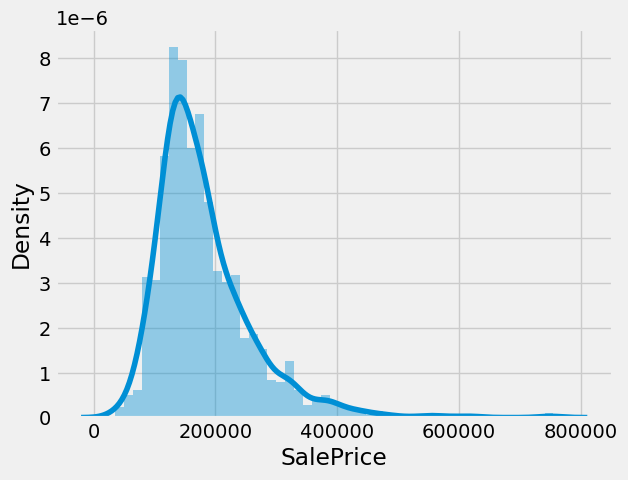

In [9]:
# Visualize the distribution of the target variable
sns.distplot(train_df['SalePrice'])


<div style="background-color:#DAAAA1; color:#19180F; font-size:15px; font-family:Verdana; padding:10px">

The next codeblock visualizes the correlation between features and the target variable using a heatmap. 

This visualization helps in understanding the strength and direction of the relationships between the features and the target variable. It can highlight features that are highly correlated (positively or negatively) with the target variable, which can be useful for feature selection or identifying potential predictors of the target variable.
    
</div>


<Axes: >

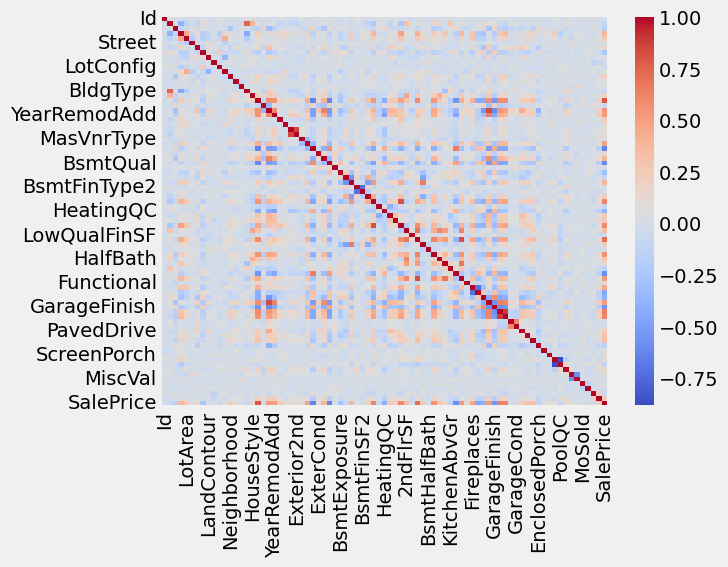

In [10]:
# Visualize the correlation between features and target variable
corr = train_df.corr()
sns.heatmap(corr, cmap='coolwarm')


<div style="background-color:#DAAAA1; color:#19180F; font-size:15px; font-family:Verdana; padding:10px">

The next codeblock visualizes the distribution of numerical features using a pair plot.

This visualization helps in understanding the patterns, relationships, and distributions of the numerical features in the dataset. It can reveal correlations or trends between variables and identify potential outliers or clusters in the data.    
</div>


In [ ]:
# Visualize the distribution of numerical features
num_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
sns.pairplot(train_df[num_cols])


<div style="background-color:#DAAAA1; color:#19180F; font-size:15px; font-family:Verdana; padding:10px">

The next codeblock fetches the numeric columns from the train_df DataFrame.    
</div>


In [12]:
# fetching numeric columns
num_cols = train_df.select_dtypes(include=['float64', 'int64']).columns


<div style="background-color:#DAAAA1; color:#19180F; font-size:15px; font-family:Verdana; padding:10px">

The next codeblock visualizes the distribution of categorical features using count plots.  

Through it, we can visualize the distribution of each categorical feature in the `train_df` DataFrame. The count plots display the frequency of each category in the respective columns, allowing us to understand the distribution and relative proportions of different categories within each categorical feature.    
</div>


In [13]:
# Visualize the distribution of categorical features
cat_cols = train_df.select_dtypes(include=['object']).columns
for col in cat_cols:
    sns.countplot(train_df[col])
    plt.show()


<div style="background-color:#DAAAA1; color:#19180F; font-size:15px; font-family:Verdana; padding:10px">

The next codeblock identifies and removes outliers from the `train_df` DataFrame using z-scores. 
    
Through it, we can identify and remove outliers from the numerical columns in the `train_df` DataFrame based on their z-scores. This can help in improving the data quality and reducing the impact of extreme values on statistical analyses or machine learning models.    
    
</div>


In [14]:
# Identify and remove outliers using z-score
z_scores = np.abs(stats.zscore(train_df[num_cols]))
train_df = train_df[(z_scores < 3).all(axis=1)]

<div style="background-color:#DAAAA1; color:#19180F; font-size:15px; font-family:Verdana; padding:10px">

Plotting the box plot in next code block to visualize the outliers that are treated.
    
Click the generated figure to zoom-in !
</div>


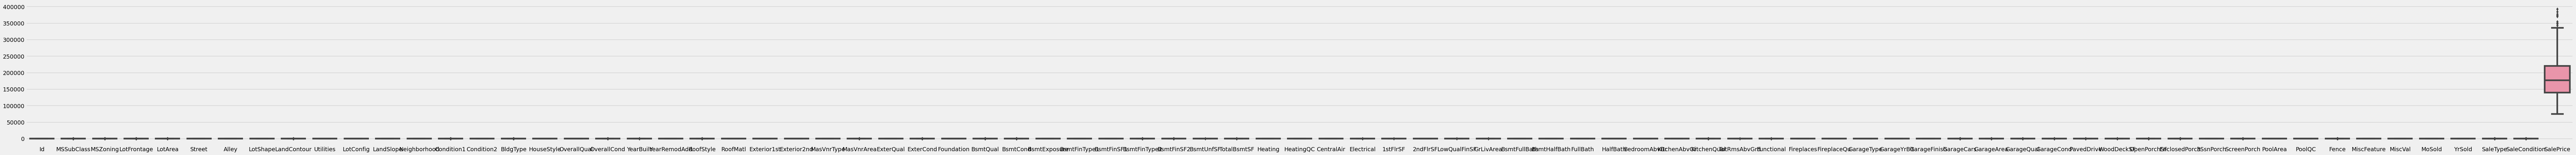

In [15]:
# Box plot
plt.figure(figsize=(100,6))
sns.boxplot(data=train_df[num_cols])
plt.show()

<div style="background-color:#DAAAA1; color:#19180F; font-size:15px; font-family:Verdana; padding:10px">

Plotting the violin plot in next code block to visualize the distribution.
    
Click the generated figure to zoom-in !    
</div>


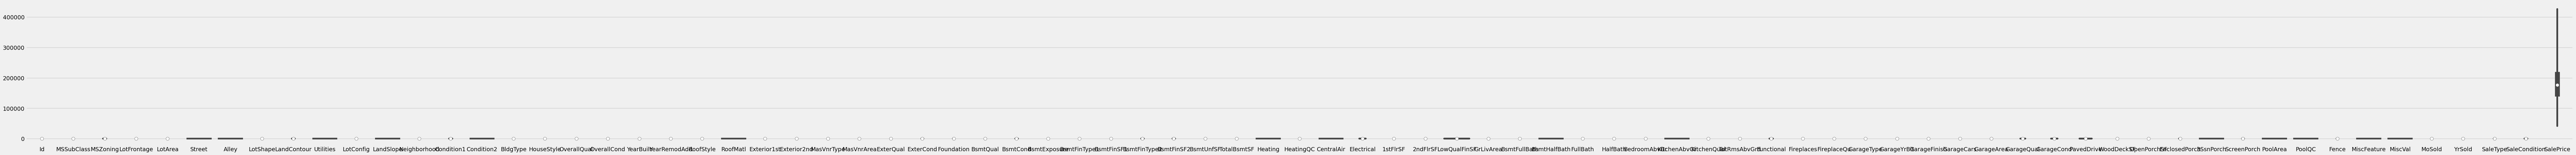

In [16]:
# Violin plot
plt.figure(figsize=(100,6))
sns.violinplot(data=train_df[num_cols])
plt.show()

<div style="background-color:#CDC997; color:#19180F; font-size:20px; font-family:Verdana; padding:10px">

3. Feature Engineering     
</div>


<div style="background-color:#DAAAA1; color:#19180F; font-size:15px; font-family:Verdana; padding:10px">

The next codeblock creates new features in both the `train_df` and `test_df` DataFrames. Following are the steps in the code :

1. For the `train_df` DataFrame:<br>
   - It creates a new feature named `TotalSF` by summing the values from the columns `TotalBsmtSF`, `1stFlrSF`, and `2ndFlrSF`. This feature represents the total square footage of the house.<br>
   - It creates a new feature named `TotalBathrooms` by summing the values from the columns `FullBath`, `HalfBath` (multiplied by 0.5), `BsmtFullBath`, and `BsmtHalfBath`. This feature represents the total number of bathrooms in the house, accounting for half bathrooms.<br>
   - It creates a new feature named `TotalPorchSF` by summing the values from the columns `OpenPorchSF`, `EnclosedPorch`, `3SsnPorch`, and `ScreenPorch`. This feature represents the total square footage of the porch areas in the house.<br>

2. For the `test_df` DataFrame:<br>
   - It creates the same new features (`TotalSF`, `TotalBathrooms`, and `TotalPorchSF`) using the same logic as in the `train_df` DataFrame. The corresponding columns are summed to calculate the values for these new features.<br>
 
</div>


In [17]:
# Create new features
train_df['TotalSF'] =train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']
train_df['TotalBathrooms'] = train_df['FullBath'] + 0.5 * train_df['HalfBath'] + train_df['BsmtFullBath'] + 0.5 * train_df['BsmtHalfBath']
train_df['TotalPorchSF'] = train_df['OpenPorchSF'] + train_df['EnclosedPorch'] + train_df['3SsnPorch'] + train_df['ScreenPorch']

test_df['TotalSF'] = test_df['TotalBsmtSF'] + test_df['1stFlrSF'] + test_df['2ndFlrSF']
test_df['TotalBathrooms'] = test_df['FullBath'] + 0.5 * test_df['HalfBath'] + test_df['BsmtFullBath'] + 0.5 * test_df['BsmtHalfBath']
test_df['TotalPSF'] = test_df['OpenPorchSF'] + test_df['EnclosedPorch'] + test_df['3SsnPorch'] + test_df['ScreenPorch']


/tmp/ipykernel_28/2827309668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['TotalSF'] =train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']
/tmp/ipykernel_28/2827309668.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['TotalBathrooms'] = train_df['FullBath'] + 0.5 * train_df['HalfBath'] + train_df['BsmtFullBath'] + 0.5 * train_df['BsmtHalfBath']
/tmp/ipykernel_28/2827309668.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

<div style="background-color:#CDC997; color:#19180F; font-size:20px; font-family:Verdana; padding:10px">

4. Model Selection    
</div>


<div style="background-color:#DAAAA1; color:#19180F; font-size:15px; font-family:Verdana; padding:10px">

The next codeblock defines a list of models for regression tasks    
</div>


In [18]:
# Define models
models = [
    LinearRegression(),
    Lasso(),
    Ridge(),
    RandomForestRegressor(),
    ExtraTreesRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor(),
    CatBoostRegressor(verbose=False),
    LGBMRegressor(),
    KNeighborsRegressor(),
    VotingRegressor(estimators=[('rf', RandomForestRegressor()), ('xgb', XGBRegressor()), ('cat', CatBoostRegressor(verbose=False))])
]

<div style="background-color:#DAAAA1; color:#19180F; font-size:15px; font-family:Verdana; padding:10px">

The next codeblock evaluates the models using cross-validation and prints the mean root mean squared error (RMSE) scores.<br>

1. It iterates over each model in the `models` list.<br>

2. For each model, it performs cross-validation using the `cross_val_score` function. The parameters used are:<br>
   - `model`: The regression model being evaluated.<br>
   - `train_df.drop('SalePrice', axis=1)`: The feature matrix, excluding the target variable 'SalePrice'.<br>
   - `train_df['SalePrice']`: The target variable.<br>
   - `cv=5`: The number of cross-validation folds <br>
   - `scoring='neg_root_mean_squared_error'`: The scoring metric used to evaluate the model. In this case, it is the negative root mean squared error (RMSE). The negative sign is used to align with maximizing the scoring metric.<br>
   - `verbose=2`: The level of verbosity for cross-validation output.<br>

3. The resulting scores for each cross-validation fold are stored in the `scores` variable.<br>

4. It prints the mean RMSE score for each model using the `type(model).__name__` to extract the name of the model class.<br>
   
</div>


In [19]:
# Evaluate models using cross-validation
for model in models:
    scores = cross_val_score(model, train_df.drop('SalePrice', axis=1), train_df['SalePrice'], cv=5, scoring='neg_root_mean_squared_error', verbose=2)
    print(f"{type(model).__name__}: {scores.mean()}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+10, tolerance: 1.594e+08
  model = cd_fast.enet_coordinate_descent(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
LinearRegression: -2038704418653.851
[CV] END .................................................... total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.348e+10, tolerance: 1.543e+08
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.261e+10, tolerance: 1.715e+08
  model = cd_fast.enet_coordinate_descent(


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.704e+10, tolerance: 1.698e+08
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.330e+10, tolerance: 1.701e+08
  model = cd_fast.enet_coordinate_descent(
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
Lasso: -19408.66831022851
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
Ridge: -19056.849531495936
[CV] END .................................................... total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
RandomForestRegressor: -21103.011572539683


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
ExtraTreesRegressor: -19190.37858189393


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
GradientBoostingRegressor: -19963.61690485971


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
XGBRegressor: -22256.621683591038


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   4.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV] END .................................................... total time=   3.6s
[CV] END .................................................... total time=   3.7s
[CV] END .................................................... total time=   3.8s
[CV] END .................................................... total time=   5.0s
CatBoostRegressor: -18880.80884282688
[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
LGBMRegressor: -20471.700940970895
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
KNeighborsRegressor: -25690.235880266984


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   5.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV] END .................................................... total time=   4.8s
[CV] END .................................................... total time=   4.7s
[CV] END .................................................... total time=   4.8s
[CV] END .................................................... total time=   5.0s
VotingRegressor: -19658.75371763412


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.2s finished


<div style="background-color:#CDC997; color:#19180F; font-size:20px; font-family:Verdana; padding:10px">

5. Hyperparameter tuning     
</div>


<div style="background-color:#DAAAA1; color:#19180F; font-size:15px; font-family:Verdana; padding:10px">

The next codeblock defines parameter grids for each model. These parameter grids specify different combinations of hyperparameters that will be used during hyperparameter tuning
    
</div>


In [20]:
# Define parameter grids for each model

param_grid_lr = {
    'fit_intercept': [True, False]
}


param_grid_lasso = {
    'alpha': [0.1, 0.5, 1.0]
}

param_grid_ridge = {
    'alpha': [0.1, 0.5, 1.0]
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_et = {
    'n_estimators': [100,200 , 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.1, 0.5, 1.0]
}

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.1, 0.5, 1.0]
}

param_grid_cb = {
    'learning_rate': [0.1, 0.5, 1.0]
}

param_grid_lgbm = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.1, 0.5, 1.0]
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

<div style="background-color:#DAAAA1; color:#19180F; font-size:15px; font-family:Verdana; padding:10px">

In the next code block, models are defined with their respective param grids    
</div>


In [21]:
# Define models with their respective parameter grids
models = [
    (LinearRegression(), param_grid_lr),
    (Lasso(), param_grid_lasso),
    (Ridge(), param_grid_ridge),
    (RandomForestRegressor(), param_grid_rf),
    (ExtraTreesRegressor(), param_grid_et),
    (GradientBoostingRegressor(), param_grid_gb),
    (XGBRegressor(), param_grid_xgb),
    (CatBoostRegressor(verbose=True), param_grid_cb),
    (LGBMRegressor(), param_grid_lgbm),
    (KNeighborsRegressor(), param_grid_knn),
    (VotingRegressor(estimators=[('rf', RandomForestRegressor()), ('xgb', XGBRegressor()), ('cat', CatBoostRegressor(verbose=True))]), None)
]

<div style="background-color:#DAAAA1; color:#19180F; font-size:15px; font-family:Verdana; padding:10px">

The next codeblock evaluates the models using cross-validation and performs hyperparameter tuning using grid search. Following are the steps:<br>

1. It initializes variables `best_model` and `best_score` to keep track of the best-performing model and its corresponding score.<br>

2. It iterates over each model and its associated parameter grid in the `models` list.<br>

3. If the `param_grid` is not `None`, it performs hyperparameter tuning using `GridSearchCV`:<br>
   - It creates a `GridSearchCV` object, specifying the model, parameter grid, cross-validation settings, scoring metric, and parallel computation settings.<br>
   - It fits the grid search object to the training data (`train_df.drop('SalePrice', axis=1)` as features and `train_df['SalePrice']` as the target variable).<br>
   - It retrieves the best estimator (`grid_search.best_estimator_`) from the grid search.<br>
   - It performs cross-validation using the best estimator, calculates the root mean squared error (RMSE) scores, and computes the mean RMSE.<br>
   - It prints the mean RMSE score for the model.<br>

4. If the `param_grid` is `None`, it performs cross-validation without hyperparameter tuning:<br>
   - It performs cross-validation using the model, the training data (`train_df.drop('SalePrice', axis=1)` as features, and `train_df['SalePrice']` as the target variable).<br>
   - It calculates the RMSE scores and computes the mean RMSE.<br>
   - It prints the mean RMSE score for the model.<br>

5. It updates the `best_model` and `best_score` variables if the current mean RMSE score is higher than the previous best score.<br>

6. Finally, it prints the best model and its corresponding score.<br>


</div>


In [22]:
# Evaluate models using cross-validation and perform hyperparameter tuning
best_model = None
best_score = float('-inf')
for model, param_grid in models:
    if param_grid is not None:
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
        grid_search.fit(train_df.drop('SalePrice', axis=1), train_df['SalePrice'])
        scores = cross_val_score(grid_search.best_estimator_, train_df.drop('SalePrice', axis=1), train_df['SalePrice'], cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
        rmse_scores = np.sqrt(-scores)
        mean_rmse = rmse_scores.mean()
        print(f"{type(model).__name__}: {mean_rmse}")
        if mean_rmse > best_score:
            best_score = mean_rmse
            best_model = grid_search.best_estimator_
    else:
        scores = cross_val_score(model, train_df.drop('SalePrice', axis=1), train_df['SalePrice'], cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
        rmse_scores = np.sqrt(-scores)
        mean_rmse = rmse_scores.mean()
        print(f"{type(model).__name__}: {mean_rmse}")
        if mean_rmse > best_score:
            best_score = mean_rmse
            best_model = model

# Print the best model and score
print(f"Best model: {type(best_model).__name__}")
print(f"Best score: {best_score}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.499e+09, tolerance: 1.594e+08
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.133e+10, tolerance: 1.543e+08
  model = cd_fast.enet_coordinate_descent(


LinearRegression: 139.04084726893691
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.631e+10, tolerance: 1.715e+08
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+10, tolerance: 1.698e+08
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.803e+10, tolerance: 1.701e

Lasso: 138.96863182088737
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Ridge: 137.69972615186194
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.4s finished


RandomForestRegressor: 143.87363575344216
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished


ExtraTreesRegressor: 138.55579180689998
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished


GradientBoostingRegressor: 142.79023223823395
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


XGBRegressor: 142.86202054011022
Fitting 5 folds for each of 3 candidates, totalling 15 fits
0:	learn: 54644.0801274	total: 56.2ms	remaining: 56.2s
1:	learn: 51432.6674203	total: 63.2ms	remaining: 31.6s
2:	learn: 48700.7746752	total: 67.6ms	remaining: 22.5s
3:	learn: 45738.2744632	total: 72.7ms	remaining: 18.1s
4:	learn: 43454.3659937	total: 79.4ms	remaining: 15.8s
5:	learn: 41122.4600795	total: 91.4ms	remaining: 15.1s
6:	learn: 39129.0975618	total: 100ms	remaining: 14.2s
7:	learn: 37205.0379958	total: 108ms	remaining: 13.4s
8:	learn: 35351.7858498	total: 118ms	remaining: 13s
9:	learn: 33677.1977697	total: 126ms	remaining: 12.5s
10:	learn: 32184.1126169	total: 135ms	remaining: 12.1s
11:	learn: 30688.0856400	total: 143ms	remaining: 11.8s
12:	learn: 29468.5520965	total: 152ms	remaining: 11.5s
13:	learn: 28458.8734132	total: 162ms	remaining: 11.4s
14:	learn: 27467.6312919	total: 171ms	remaining: 11.3s
15:	learn: 26498.0549877	total: 181ms	remaining: 11.2s
16:	learn: 25583.3438797	total: 1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


864:	learn: 0.0000000	total: 4.33s	remaining: 676ms
865:	learn: 0.0000000	total: 4.34s	remaining: 671ms
866:	learn: 0.0000000	total: 4.34s	remaining: 666ms
867:	learn: 0.0000000	total: 4.35s	remaining: 661ms
868:	learn: 0.0000000	total: 4.35s	remaining: 656ms
869:	learn: 0.0000000	total: 4.35s	remaining: 651ms
870:	learn: 0.0000000	total: 4.36s	remaining: 645ms
871:	learn: 0.0000000	total: 4.36s	remaining: 640ms
872:	learn: 0.0000000	total: 4.37s	remaining: 635ms
873:	learn: 0.0000000	total: 4.37s	remaining: 630ms
874:	learn: 0.0000000	total: 4.37s	remaining: 625ms
875:	learn: 0.0000000	total: 4.38s	remaining: 620ms
876:	learn: 0.0000000	total: 4.38s	remaining: 614ms
877:	learn: 0.0000000	total: 4.38s	remaining: 609ms
878:	learn: 0.0000000	total: 4.39s	remaining: 604ms
879:	learn: 0.0000000	total: 4.39s	remaining: 599ms
880:	learn: 0.0000000	total: 4.39s	remaining: 594ms
881:	learn: 0.0000000	total: 4.4s	remaining: 589ms
882:	learn: 0.0000000	total: 4.4s	remaining: 583ms
883:	learn: 0.

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.0s finished


CatBoostRegressor: 136.5533447818882
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


LGBMRegressor: 142.8208977650504
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KNeighborsRegressor: 159.47325199824533
874:	learn: 276.0422105	total: 3.96s	remaining: 566ms
875:	learn: 273.8035150	total: 3.97s	remaining: 562ms
876:	learn: 273.3175750	total: 3.98s	remaining: 558ms
877:	learn: 271.5559954	total: 3.99s	remaining: 554ms
878:	learn: 270.8118365	total: 4s	remaining: 551ms
879:	learn: 270.4475235	total: 4.01s	remaining: 547ms
880:	learn: 270.1253240	total: 4.02s	remaining: 542ms
881:	learn: 269.7770281	total: 4.03s	remaining: 539ms
882:	learn: 267.2035066	total: 4.04s	remaining: 535ms
883:	learn: 266.2156469	total: 4.04s	remaining: 531ms
884:	learn: 265.1276945	total: 4.05s	remaining: 527ms
885:	learn: 265.0049110	total: 4.07s	remaining: 523ms
886:	learn: 263.7650735	total: 4.07s	remaining: 519ms
887:	learn: 261.9794982	total: 4.08s	remaining: 515ms
888:	learn: 261.9170447	total: 4.09s	remaining: 511ms
889:	learn: 261.0678003	total: 4.1s	remaining: 507ms
890:	learn: 260.6039437	total: 4.11s	remaining: 503ms
891:	learn: 259.3508115	total: 4.12s	remaining

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.2s finished


<div style="background-color:#CDC997; color:#19180F; font-size:20px; font-family:Verdana; padding:10px">

6. Feature Importance     
</div>


<div style="background-color:#DAAAA1; color:#19180F; font-size:15px; font-family:Verdana; padding:10px">

The next codeblock calculates the feature importances using a trained `RandomForestRegressor` model. Following are the steps:<br>

1. It creates a `RandomForestRegressor` instance named `rf` and passes the best hyperparameters (`**grid_search.best_params_`) obtained from a grid search or hyperparameter tuning process. The `RandomForestRegressor` is initialized with these best hyperparameters.<br>

2. It fits the `rf` model on the feature matrix `train_df.drop('SalePrice', axis=1)` and the target variable `train_df['SalePrice']`. This step trains the random forest model using the training data.<br>

3. It retrieves the feature importances using the `feature_importances_` attribute of the trained `rf` model. The `feature_importances_` attribute provides an array-like object that represents the importance of each feature in the trained model. The importance values indicate how much each feature contributes to the predictions made by the random forest model.<br>

The resulting feature importances are stored in the `importances` variable. Each value in the `importances` array corresponds to a feature in the same order as they appear in the feature matrix. Higher values indicate greater importance, indicating that the corresponding feature has a stronger influence on the model's predictions.<br>
    
</div>


In [25]:
# Get feature importances
rf = RandomForestRegressor()
rf.fit(train_df.drop('SalePrice', axis=1), train_df['SalePrice'])
importances = rf.feature_importances_


<div style="background-color:#DAAAA1; color:#19180F; font-size:15px; font-family:Verdana; padding:10px">

The next codeblock visualizes the feature importances calculated from the `RandomForestRegressor` model. FOllowing are the steps:<br>

1. It creates a `pd.Series` object named `feat_importances` using the feature importances (`importances`) calculated from the model. The `importances` array is passed as the data, and the index is set to the column names of the feature matrix (`train_df.drop('SalePrice', axis=1).columns`).<br>

2. It selects the top 20 features with the largest importances using the `nlargest` method of the `feat_importances` series. These features are the ones with the highest importance values.<br>

3. It plots the selected features as horizontal bar plots using the `plot` method with `kind='barh'`. This creates a bar chart where each bar represents a feature, and the length of the bar corresponds to its importance value. The features are ordered from top to bottom based on their importance.<br>


</div>


<Axes: >

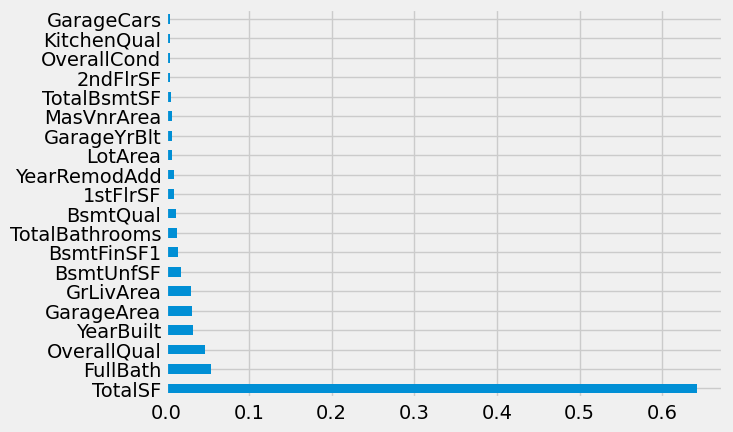

In [26]:
# Visualize feature importances
feat_importances = pd.Series(importances, index=train_df.drop('SalePrice', axis=1).columns)
feat_importances.nlargest(20).plot(kind='barh')


<div style="background-color:#DAAAA1; color:#19180F; font-size:15px; font-family:Verdana; padding:10px">

The next code block generates prediction on test set
    
</div>


In [32]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF,TotalBathrooms,TotalPorchSF
0,-1.730865,0.073375,3,-0.240987,-0.207142,1,2,3,3,0,4,0,5,2,2,0,5,0.651479,-0.5172,1.050994,0.878668,1,1,12,13,1,0.509269,2,4,2,2,3,3,2,0.575425,5,-0.288653,-0.944591,-0.459303,1,...,1.161852,-0.120242,0.370333,1.10781,-0.241061,0.789741,1.227585,0.163779,-0.211454,2,0.912210,6,-0.951226,5,1,1.035549,1,0.311725,0.351000,4,4,2,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,3,4,4,-0.087688,-1.599111,0.138777,8,4,208500,-0.090885,2.390813,-0.529369
2,-1.726120,0.073375,3,-0.112144,0.073480,1,2,0,3,0,4,0,5,2,2,0,5,0.651479,-0.5172,0.984752,0.830215,1,1,12,13,1,0.321024,2,4,2,2,3,2,2,0.092907,5,-0.288653,-0.301643,-0.313369,1,...,1.189351,-0.120242,0.515013,1.10781,-0.241061,0.789741,1.227585,0.163779,-0.211454,2,-0.318683,6,0.600495,4,1,0.956919,1,0.311725,0.631726,4,4,2,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,3,4,4,-0.087688,0.990891,0.138777,8,4,223500,0.248156,2.390813,-0.816234
4,-1.721374,0.073375,3,0.575018,0.375148,1,2,0,3,0,2,0,15,2,2,0,5,1.374795,-0.5172,0.951632,0.733308,1,1,12,13,1,1.361910,2,4,2,2,3,0,2,0.463568,5,-0.288653,-0.174865,0.199680,1,...,1.617877,-0.120242,1.299326,1.10781,-0.241061,0.789741,1.227585,1.390023,-0.211454,2,1.527656,6,0.600495,4,1,0.917604,1,1.650307,1.698485,4,4,2,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,3,4,4,-0.087688,2.100892,0.138777,8,4,250000,1.771946,2.390813,-0.182112
6,-1.716629,-0.872563,3,0.188489,-0.043379,1,2,3,3,0,4,0,21,2,2,0,2,1.374795,-0.5172,1.084115,0.975575,1,1,12,13,3,0.453903,2,4,2,0,3,0,2,2.029558,5,-0.288653,-0.566519,1.433276,1,...,-0.795163,-0.120242,0.339875,1.10781,-0.241061,0.789741,-0.761621,0.163779,-0.211454,2,0.296763,6,0.600495,2,1,1.074864,1,0.311725,0.762732,4,4,2,1.283007,0.156111,-0.359325,-0.116339,-0.270208,-0.068692,3,4,4,-0.087688,0.620891,-0.614439,8,4,307000,2.013106,1.396210,-0.589762
10,-1.707138,-0.872563,3,-0.026249,0.068469,1,2,3,3,0,4,0,19,2,2,0,2,-0.795151,-0.5172,-0.207594,-0.962566,3,1,6,6,2,-0.575909,3,4,1,3,3,3,4,1.014077,5,-0.288653,-0.980813,-0.039743,1,...,-0.795163,-0.120242,-0.905127,1.10781,-0.241061,-1.026041,-0.761621,0.163779,-0.211454,3,-0.934130,6,-0.951226,5,5,-0.458417,2,-1.026858,-0.416317,4,4,2,-0.752176,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,3,4,4,-0.087688,-1.599111,0.138777,8,4,129500,-1.152218,-0.419572,-1.450356


In [33]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF,TotalBathrooms,TotalPSF
0,1.733238,-0.872563,2,0.403227,0.110763,1,2,3,3,0,4,0,12,1,2,0,2,-0.795151,0.381743,-0.340077,-1.156380,1,1,12,13,2,-0.575909,3,4,1,3,3,3,4,0.053428,3,0.604293,-0.672923,-0.400017,1,...,-0.689929,-0.795163,-0.120242,-1.179256,-0.819964,-0.241061,-1.026041,-0.761621,-1.062465,-0.211454,3,-0.934130,6,-0.951226,5,1,-0.615676,2,-1.026858,1.202536,4,4,2,0.365179,-0.704483,-0.359325,-0.116339,1.882709,-0.068692,3,2,4,-0.087688,-0.119110,1.64521,8,4,-1.885109,-2.347346,0.702562
1,1.735610,-0.872563,3,0.446175,0.375850,1,2,0,3,0,0,0,12,2,2,0,2,-0.071836,0.381743,-0.439440,-1.301740,3,1,13,14,1,0.022046,3,4,1,3,3,3,0,1.051363,5,-0.288653,-0.365032,0.619239,1,...,0.430511,-0.795163,-0.120242,-0.354966,-0.819964,-0.241061,-1.026041,1.227585,0.163779,-0.211454,2,-0.318683,6,-0.951226,5,1,-0.733621,2,-1.026858,-0.753188,4,4,2,2.384400,-0.160950,-0.359325,-0.116339,-0.270208,-0.068692,3,4,0,25.116309,-0.119110,1.64521,8,4,0.254587,-1.352743,-0.906823
2,1.737983,0.073375,3,0.145542,0.332053,1,2,0,3,0,4,0,8,2,2,0,5,-0.795151,-0.517200,0.852269,0.636400,1,1,12,13,2,-0.575909,3,4,2,2,3,3,2,0.761852,5,-0.288653,-0.974021,-0.295127,1,...,-0.607125,0.811239,-0.120242,0.216136,-0.819964,-0.241061,0.789741,1.227585,0.163779,-0.211454,3,-0.318683,6,0.600495,4,1,0.799659,0,0.311725,0.042202,4,4,2,0.939819,-0.191147,-0.359325,-0.116339,-0.270208,-0.068692,3,2,4,-0.087688,-1.229111,1.64521,8,4,-0.091013,0.463038,-0.937019
3,1.740356,0.073375,3,0.317332,-0.054002,1,2,0,3,0,4,0,8,2,2,0,5,-0.071836,0.381743,0.885390,0.636400,1,1,12,13,1,-0.465177,3,4,2,3,3,3,2,0.347326,5,-0.288653,-0.550672,-0.299687,1,...,-0.612300,0.758532,-0.120242,0.168544,-0.819964,-0.241061,0.789741,1.227585,0.163779,-0.211454,2,0.296763,6,0.600495,2,1,0.838974,0,0.311725,-0.013943,4,4,2,2.121024,-0.160950,-0.359325,-0.116339,-0.270208,-0.068692,3,4,4,-0.087688,-0.119110,1.64521,8,4,-0.153455,0.463038,-0.906823
4,1.742728,1.492282,3,-1.185834,-0.552407,1,2,0,1,0,4,0,22,2,2,4,2,1.374795,-0.517200,0.686666,0.345679,1,1,6,6,2,-0.575909,2,4,2,2,3,3,0,-0.396190,5,-0.288653,1.018211,0.507509,1,...,0.303718,-0.795163,-0.120242,-0.448246,-0.819964,-0.241061,0.789741,-0.761621,-1.062465,-0.211454,2,-0.934130,6,-0.951226,5,1,0.603085,1,0.311725,0.154492,4,4,2,-0.752176,0.533564,-0.359325,-0.116339,2.313293,-0.068692,3,4,4,-0.087688,-1.969111,1.64521,8,4,0.016063,-0.531565,2.371193


In [34]:
test_df = test_df.rename(columns={'TotalPSF': 'TotalPorchSF'})


In [35]:
# Make predictions on test set
predictions = best_model.predict(test_df)


<div style="background-color:#DAAAA1; color:#19180F; font-size:15px; font-family:Verdana; padding:10px">

The predictions v/s actual values are visualized in the next code block via a scatter plot.    
</div>


<Axes: xlabel='Id'>

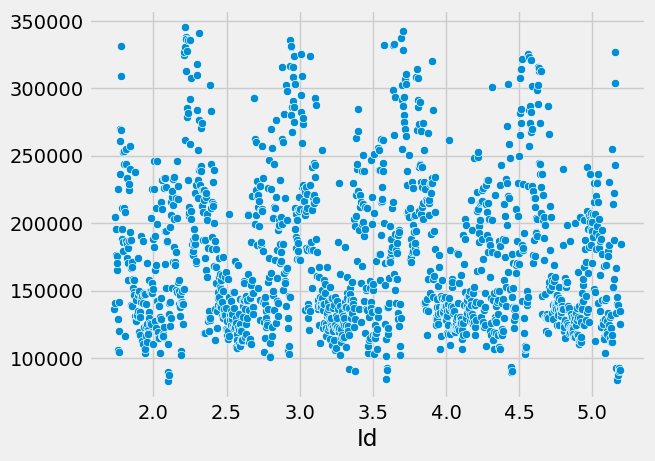

In [41]:
# Visualize predicted vs actual values
sns.scatterplot(x=test_df['Id'], y=predictions)


<div style="background-color:#CDC997; color:#19180F; font-size:20px; font-family:Verdana; padding:10px">

7. Model Selection    
</div>


<div style="background-color:#DAAAA1; color:#19180F; font-size:15px; font-family:Verdana; padding:10px">

The next codeblock is used to interpret the model using SHAP (SHapley Additive exPlanations) values. Following are the steps:<br>

1. It imports the `shap` library, which provides tools for model interpretation using SHAP values.<br>

2. It creates a `TreeExplainer` instance named `explainer` by passing the trained `rf` model to the `TreeExplainer` class. The `TreeExplainer` class is specifically designed for tree-based models, such as random forests.<br>

3. It calculates the SHAP values for the `test_df` data, excluding the target variable, by calling the `shap_values` method of the `explainer` object. The SHAP values represent the contribution of each feature to the predicted output for each instance in the test data.<br>

4. It generates a summary plot of the SHAP values using the `summary_plot` function from the `shap` library. This plot provides an overview of the feature importances and their impact on the model predictions. The features are ranked by the magnitude of their SHAP values, and each dot on the plot represents a feature's impact on a particular instance. The position of the dot on the x-axis indicates the SHAP value, and the color represents the feature value (red for high, blue for low).<br>
   
</div>


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


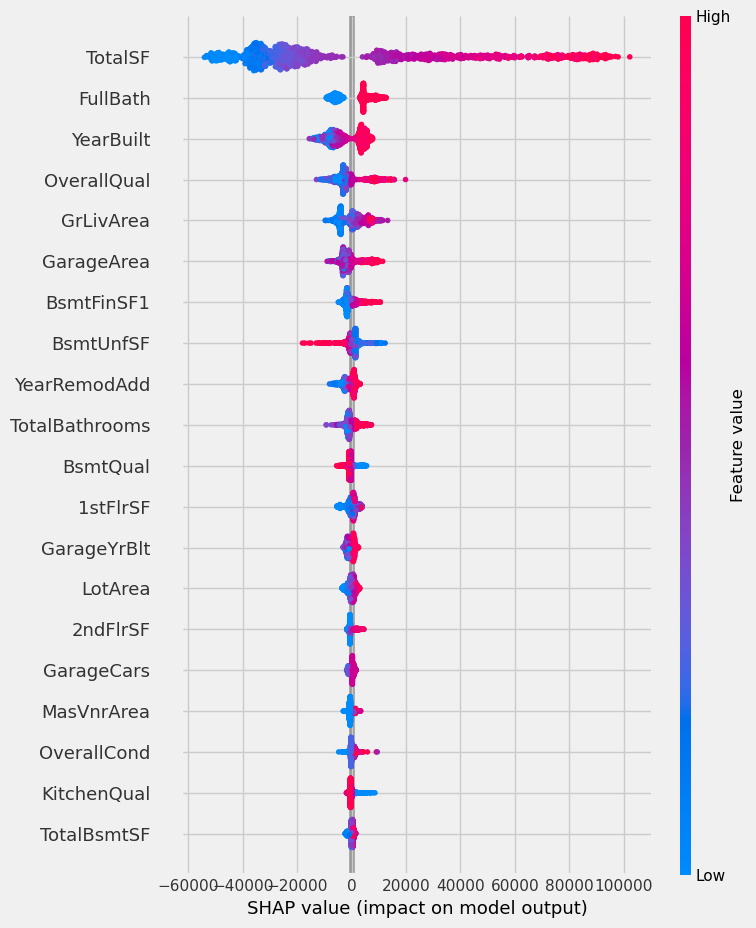

In [42]:
# Interpret model using SHAP values
import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(test_df)
shap.summary_plot(shap_values, test_df)



<div style="background-color:#CDC997; color:#19180F; font-size:20px; font-family:Verdana; padding:10px">

8. Generating Submission     
</div>


<div style="background-color:#DAAAA1; color:#19180F; font-size:15px; font-family:Verdana; padding:10px">

Creating submission file from the generated predictions in the next codeblock.    
</div>


In [43]:
# Create submission file
submission_df = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': predictions})
submission_df.to_csv('submission.csv', index=False)